In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In this notebook, I will load Gorilla data, mask it based on the bed-mask, and generate statistics based on binned diversity and runs of homozygosity.
All analysis should be ind-based, that is analysis that can be performed on only a single sample.

Masking process: Create windows that all have 10kb "useful" bases, which means that you first filter out all variants not in the bed, and then generate intervals that have 10kb callable bases.

Easier process: When generating the zarr files, mask all sites through bcftools that aren't in the callable regions.
If that is done, the only thing that needs to be done here is to create 10kb intervals of callable bases, which I will implement here.

In [2]:
cov_summaries = glob.glob("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Gorilla_gorilla_gorilla/cov/*")
df_l = []
for p in cov_summaries:
    df = pd.read_csv(p, sep="\t", names=["Name", "Contig", "start", "end", "length", "?", "coverage"])
    df["ID"] = p.split("/")[-1].split(".")[0]
    df_l.append(df)
df_cov = pd.concat(df_l)

In [3]:
df_cov["Contig_type"] = ["chrX" if x == "postPAR1" else "non-X" for x in df_cov.Name]
df_group = df_cov.groupby(["ID", "Contig_type"])["coverage"].median().reset_index()
non_X = df_group.loc[df_group.Contig_type == "non-X"]
df_cov["aut_cov"] = df_cov.ID.map(dict(zip(non_X.ID, non_X.coverage)))
df_cov["relative_cov"] = df_cov.coverage/df_cov.aut_cov

In [4]:
df_cov

,Name,Contig,start,end,length,?,coverage,ID,Contig_type,aut_cov,relative_cov
0,NC_073224.2,NC_073224.2,1,243847345,239752752,4203819301,17.5340,SAMN01920495,non-X,17.8356,0.983090
1,NC_086017.1,NC_086017.1,1,215253457,212720055,3966143448,18.6449,SAMN01920495,non-X,17.8356,1.045376
2,NC_073227.2,NC_073227.2,1,215373162,210274335,4141899393,19.6976,SAMN01920495,non-X,17.8356,1.104398
3,NC_073228.2,NC_073228.2,1,195332687,192154248,3471288490,18.0651,SAMN01920495,non-X,17.8356,1.012868
4,NC_073229.2,NC_073229.2,1,199452338,194795376,3670749101,18.8441,SAMN01920495,non-X,17.8356,1.056544
...,...,...,...,...,...,...,...,...,...,...,...
23,prePAR1,NC_073247.2,1,9544188,9083462,187557250,20.6482,SAMEA5204235,non-X,32.2785,0.639689
24,PAR1,NC_073247.2,9544189,12039748,2481357,65130303,26.2479,SAMEA5204235,non-X,32.2785,0.813170
25,postPAR1,NC_073247.2,12039749,177558554,164693441,3000052443,18.2160,SAMEA5204235,chrX,32.2785,0.564338
26,NC_073248.2,NC_073248.2,1,67405748,63506830,1403762623,22.1041,SAMEA5204235,non-X,32.2785,0.684793


In [5]:
df_x_only = df_cov.loc[df_cov.Contig_type == "chrX"]
df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]

/tmp/64159536/ipykernel_2310058/1432902879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_only["Sex"] = [0 if x <= 0.75 else 1 for x in df_x_only.relative_cov]


In [6]:
ds = sg.load_dataset("../data/Gorilla_gorilla_gorilla")
ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(dict(zip(df_x_only.ID,df_x_only.Sex
                                                                              ))), dims="samples")

Using the bed mask.

In [7]:
bed_file = pd.read_csv("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Gorilla_gorilla_gorilla/filteredVCF/pos_bed_cov_based/Gorilla_gorilla_gorilla_batch7_fploidy2_mploidy2.bed",
                       sep="\t", names=["chrom", "start", "end"])

In [8]:
(bed_file.end.sum()-bed_file.start.sum())/bed_file.end.max() #86 % in the callable region.

0.8593319712503096

In [9]:
bed_file["interval_size"] = bed_file.end-bed_file.start

<Axes: xlabel='interval_size', ylabel='Count'>

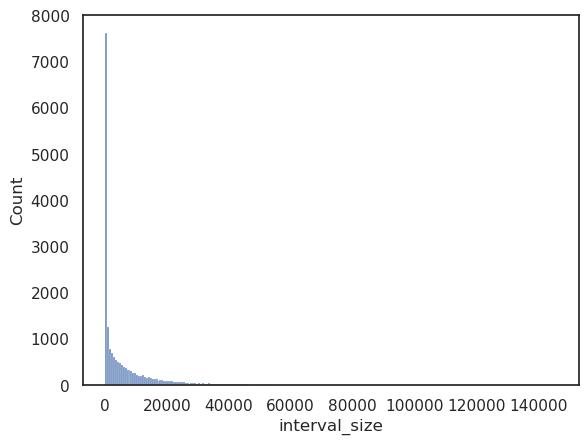

In [10]:
sns.histplot(bed_file, x="interval_size")

Load in all bed files, create a filter which removes sites which aren't callable enough.

In [11]:
bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Gorilla_gorilla_gorilla/filteredVCF/pos_bed_cov_based/Gorilla_gorilla_gorilla_batch*_fploidy2_mploidy1.bed"
bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/Gorilla_gorilla_gorilla/filteredVCF/pos_bed_cov_based/Gorilla_gorilla_gorilla_batch*_fploidy2_mploidy2.bed"

bed_l = []
for b in glob.glob(bed_path_x):
    bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
    bed_l.append(bed_file)
bed_x = pd.concat(bed_l)

bed_l = []
for b in glob.glob(bed_path_all):
    bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
    bed_l.append(bed_file)
bed_files = pd.concat(bed_l)
bed_files = bed_files.loc[bed_files.chrom != bed_x.chrom.unique()[0]]
bed_files = pd.concat([bed_files, bed_x])

In [12]:
bed_files

,chrom,start,end
0,NC_073230.2,37923,38052
1,NC_073230.2,41788,42138
2,NC_073230.2,55572,55726
3,NC_073230.2,55768,56165
4,NC_073230.2,56516,56821
...,...,...,...
17746,NC_073247.2,177536161,177536335
17747,NC_073247.2,177542752,177542916
17748,NC_073247.2,177544657,177544840
17749,NC_073247.2,177544878,177545213


In [13]:
window_size = 10000
start_l, end_l = [], []
for b in [bed_x]:
    b["w_s"] = b.end-b.start
    w_start = bed_x.start.iloc[0]
    current_size = 0
    for i, j, k in zip(b.start, b.end, b.w_s):
        # Current window encapsulates the final stretch of the interval.
        if current_size + k >= window_size:
            start_l.append(w_start), end_l.append(i+(window_size-current_size))
            w_start = i+(window_size-current_size)
            # If the window still contains full intervals, contigous windows until it cant.
            for x in range((k-window_size+current_size)//window_size):
                start_l.append(w_start), end_l.append(w_start+window_size)
                w_start += window_size
            current_size = j-w_start
        # Current window does not encapsulate per definition, so it has to be added to current size but nothing else.
        else:
            current_size += k

In [14]:
test_df = pd.DataFrame({"chrom": "NC_073247.2", "interval_start": start_l, "interval_end": end_l})
test_df["window_size"] = test_df.interval_end-test_df.interval_start

In [15]:
test_df.window_size.min()

10000

In [16]:
ds.sel(contigs=[0, 23])

<xarray.Dataset> Size: 6GB
Dimensions:               (variants: 21463034, samples: 46, ploidy: 2,
                           contigs: 2, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 987MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    contig_id             (contigs) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    contig_length         (contigs) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 172MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 21MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 43MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [17]:
ds.sel(variants=slice(0, 10000000), contigs=[0, 1])

<xarray.Dataset> Size: 3GB
Dimensions:               (variants: 10000000, samples: 46, ploidy: 2,
                           contigs: 2, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 920MB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 920MB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 460MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    contig_id             (contigs) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    contig_length         (contigs) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 80MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 10MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 20MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 40MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 40MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [18]:
sg.diversity(sg.window_by_position(ds.sel(variants=slice(0, 10000000), contigs=[0, 1, 2]), size=10000))

<xarray.Dataset> Size: 4GB
Dimensions:               (windows: 51782, cohorts: 2, variants: 10000000,
                           alleles: 2, samples: 46, ploidy: 2, contigs: 3,
                           filters: 2, region_index_values: 21487,
                           region_index_fields: 6)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: windows, cohorts, variants, alleles, ploidy,
                                contigs, filters, region_index_values,
                                region_index_fields
Data variables: (12/23)
    stat_diversity        (windows, cohorts) float64 829kB dask.array<chunksize=(569, 2), meta=np.ndarray>
    cohort_allele_count   (variants, cohorts, alleles) uint64 320MB dask.array<chunksize=(1000, 2, 2), meta=np.ndarray>
    call_allele_count     (variants, samples, alleles) uint8 920MB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    window_contig         (windows) int64 414kB 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2
    window_start          (windows) int64 414kB 0 0 0 ... 3573442 3573544
    window_stop           (windows) int64 414kB 0 0 0 ... 3573544 3573625
    ...                    ...
    variant_id            (variants) object 80MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 10MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 20MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 40MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 40MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [19]:
ds_X = ds.sel(contigs=[23], variants=(ds.variant_contig == 23).compute())

In [20]:
#ds_X["interval_contig_name"] = ds_X["variant_contig"] # I guess I have to 

In [21]:
ds_X

<xarray.Dataset> Size: 179MB
Dimensions:               (variants: 666044, samples: 46, ploidy: 2,
                           contigs: 1, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 61MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 61MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 31MB dask.array<chunksize=(999, 46), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 5MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 666kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 1MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [22]:
quality_windows = test_df.loc[test_df.window_size <= window_size*1.1]
quality_windows

,chrom,interval_start,interval_end,window_size
13,NC_073247.2,12047456,12057780,10324
14,NC_073247.2,12057780,12067781,10001
15,NC_073247.2,12067781,12077891,10110
16,NC_073247.2,12077891,12088654,10763
17,NC_073247.2,12088654,12098727,10073
...,...,...,...,...
14434,NC_073247.2,167525482,167535482,10000
14436,NC_073247.2,167556700,167566700,10000
14437,NC_073247.2,167566700,167576700,10000
14439,NC_073247.2,167588695,167598696,10001


In [23]:
ds_X["interval_contig_name"] = (["intervals"], quality_windows.chrom)
ds_X["interval_start"] = (["intervals"], quality_windows.interval_start)
ds_X["interval_stop"] = (["intervals"], quality_windows.interval_end)
ds_X = sg.window_by_interval(ds_X)

In [24]:
ds.sel(contigs=[23], variants=(ds.variant_contig == 23).compute())

<xarray.Dataset> Size: 179MB
Dimensions:               (variants: 666044, samples: 46, ploidy: 2,
                           contigs: 1, filters: 2, region_index_values: 21487,
                           region_index_fields: 6, alleles: 2)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 61MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 61MB dask.array<chunksize=(999, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 31MB dask.array<chunksize=(999, 46), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 5MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 666kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 1MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [25]:
div_array = sg.diversity(ds_X.chunk({"variants": 50000}))["stat_diversity"]
div_array.values

array([[18.66587302, 19.45490064],
       [14.70555556, 16.30448154],
       [13.68650794, 12.73199616],
       ...,
       [ 1.26587302,  2.81052464],
       [ 0.75793651,  3.48373379],
       [ 2.92063492,  4.62087291]])

In [26]:
div_array[:,0]

<xarray.DataArray 'stat_diversity' (windows: 13846)> Size: 111kB
dask.array<getitem, shape=(13846,), dtype=float64, chunksize=(1578,), chunktype=numpy.ndarray>
Dimensions without coordinates: windows
Attributes:
    comment:  Genetic diversity (also known as "Tajima’s pi") for cohorts.

In [27]:
quality_windows["male_div"] = div_array[:,0]
quality_windows["female_div"] = div_array[:,1]

/tmp/64159536/ipykernel_2310058/95869910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_windows["male_div"] = div_array[:,0]
/tmp/64159536/ipykernel_2310058/95869910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_windows["female_div"] = div_array[:,1]


<Axes: xlabel='female_div', ylabel='Count'>

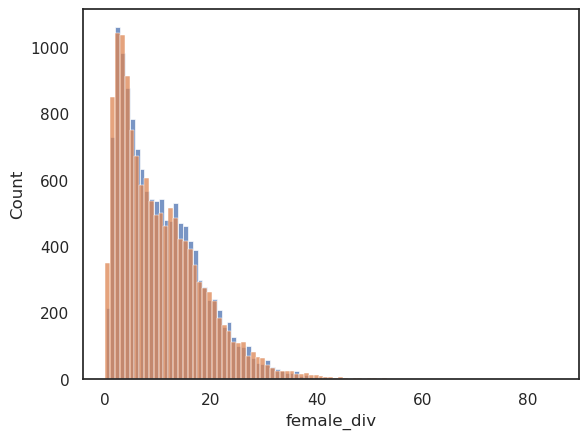

In [28]:
sns.histplot(quality_windows.female_div)
sns.histplot(quality_windows.male_div)

In [29]:
quality_windows.female_div.mean(), quality_windows.male_div.mean()

(10.57318413650943, 10.338627511010666)

Generalizable workflow:

In [30]:
def interval_creator(bed_l, window_size):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    df_l = []
    for c in bed_l.chrom.unique():
        start_l, end_l = [], []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_size = 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Current window encapsulates the final stretch of the interval.
            if current_size + k >= window_size:
                start_l.append(w_start), end_l.append(i+(window_size-current_size))
                w_start = i+(window_size-current_size)
                # If the window still contains full intervals, contigous windows until it cant.
                for x in range((k-window_size+current_size)//window_size):
                    start_l.append(w_start), end_l.append(w_start+window_size)
                    w_start += window_size
                current_size = j-w_start
            # Current window does not encapsulate per definition, so it has to be added to current size but nothing else.
            else:
                current_size += k
        df_l.append(pd.DataFrame({"chrom": c, "interval_start": start_l, "interval_end": end_l}))
    return pd.concat(df_l)

In [31]:
interval_df = interval_creator(bed_files, 10000)

In [32]:
interval_df["interval_size"] = interval_df.interval_end-interval_df.interval_start
quality_windows = interval_df.loc[interval_df.interval_size <= 11000]

In [33]:
df_interval = ds
df_interval["interval_contig_name"] = (["intervals"], quality_windows.chrom)
df_interval["interval_start"] = (["intervals"], quality_windows.interval_start)
df_interval["interval_stop"] = (["intervals"], quality_windows.interval_end)
df_interval = sg.window_by_interval(df_interval)

In [34]:
df_interval

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 267157, variants: 21463034, samples: 46,
                           ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6,
                           alleles: 2, intervals: 267165)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: windows, variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles, intervals
Data variables: (12/23)
    window_contig         (windows) int64 2MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 2MB 274 343 394 ... 21462731 21462756
    window_stop           (windows) int64 2MB 343 394 486 ... 21462756 21462791
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 987MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    ...                    ...
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 1 1 1 1 0 1 1 1 ... 1 1 1 1 1 1 1
    interval_contig_name  (intervals) object 2MB 'NC_073230.2' ... 'NC_073247.2'
    interval_start        (intervals) int64 2MB 6435061 6589335 ... 167598696
    interval_stop         (intervals) int64 2MB 6445920 6599596 ... 167608697
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [35]:
ds_int_div =  sg.diversity(df_interval.chunk({"variants": 50000}))
div_array = ds_int_div["stat_diversity"]
div_array

<xarray.DataArray 'stat_diversity' (windows: 267157, cohorts: 2)> Size: 4MB
dask.array<blockwise_moving_stat, shape=(267157, 2), dtype=float64, chunksize=(1569, 2), chunktype=numpy.ndarray>
Dimensions without coordinates: windows, cohorts
Attributes:
    comment:  Genetic diversity (also known as "Tajima’s pi") for cohorts.

In [36]:
quality_windows

,chrom,interval_start,interval_end,interval_size
37,NC_073230.2,6435061,6445920,10859
44,NC_073230.2,6589335,6599596,10261
55,NC_073230.2,7539279,7549556,10277
56,NC_073230.2,7549556,7560105,10549
57,NC_073230.2,7560105,7570105,10000
...,...,...,...,...
14434,NC_073247.2,167525482,167535482,10000
14436,NC_073247.2,167556700,167566700,10000
14437,NC_073247.2,167566700,167576700,10000
14439,NC_073247.2,167588695,167598696,10001


In [37]:
pd.unique(ds_int_div.window_contig.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [38]:
ds_X_div = ds_int_div.sel(windows = (ds_int_div.window_contig == 23).compute())
ds_aut_div = ds_int_div.sel(windows = (ds_int_div.window_contig != 23).compute())

<Axes: ylabel='Count'>

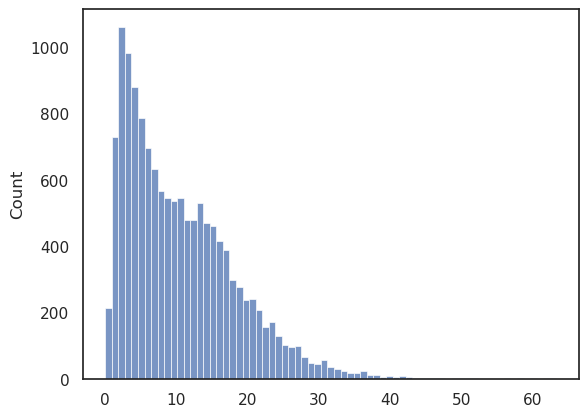

In [39]:
sns.histplot(ds_X_div["stat_diversity"][:,1])

<Axes: ylabel='Count'>

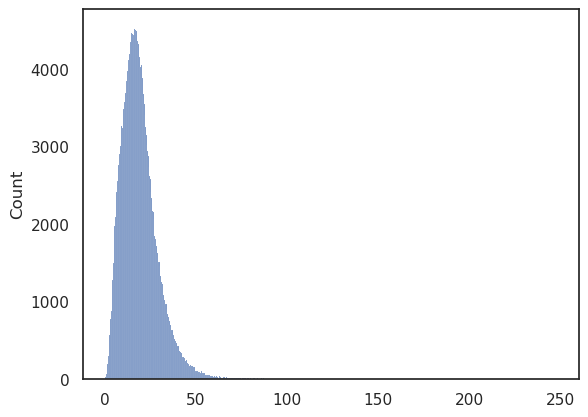

In [40]:
sns.histplot(ds_aut_div["stat_diversity"][:,1])

In [41]:
x_div = ds_X_div["stat_diversity"][:,1]
aut_div = ds_aut_div["stat_diversity"][:,1]

In [42]:
pd.qcut(x_div, 10)

[(16.726, 21.187], (13.871, 16.726], (11.303, 13.871], (13.871, 16.726], (13.871, 16.726], ..., (0.0615, 2.287], (3.502, 4.972], (2.287, 3.502], (2.287, 3.502], (3.502, 4.972]]
Length: 13846
Categories (10, interval[float64, right]): [(0.0615, 2.287] < (2.287, 3.502] < (3.502, 4.972] < (4.972, 6.739] ... (11.303, 13.871] < (13.871, 16.726] < (16.726, 21.187] < (21.187, 63.279]]

In [43]:
pd.qcut(aut_div, 10)

[(15.383, 17.512], (10.709, 13.177], (19.76, 22.384], (19.76, 22.384], (17.512, 19.76], ..., (13.177, 15.383], (0.172, 7.709], (13.177, 15.383], (19.76, 22.384], (22.384, 25.846]]
Length: 253311
Categories (10, interval[float64, right]): [(0.172, 7.709] < (7.709, 10.709] < (10.709, 13.177] < (13.177, 15.383] ... (19.76, 22.384] < (22.384, 25.846] < (25.846, 31.554] < (31.554, 247.607]]

In [44]:
21.187/31.554, 2.287/7.709

(0.6714521138365976, 0.2966662342716306)

In [45]:
(x_div.mean()/aut_div.mean()).compute()

<xarray.DataArray 'stat_diversity' ()> Size: 8B
array(0.5584613)

In [46]:
x_div_q = np.quantile(x_div.values, q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
aut_div_q = np.quantile(aut_div.values, q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [55]:
x_div_q

array([ 2.28704425,  3.50192975,  4.97248134,  6.73853312,  8.93268591,
       11.30326538, 13.87084069, 16.72562907, 21.18666132])

In [54]:
aut_div_q

array([ 7.70898392, 10.70893204, 13.17682806, 15.38326857, 17.51197486,
       19.75994316, 22.38389529, 25.84563597, 31.55432078])

In [47]:
x_div_q/aut_div_q

array([0.29667259, 0.32701018, 0.37736558, 0.438043  , 0.51009015,
       0.57202925, 0.61967948, 0.64713552, 0.67143455])

[(0.0, 1.0)]

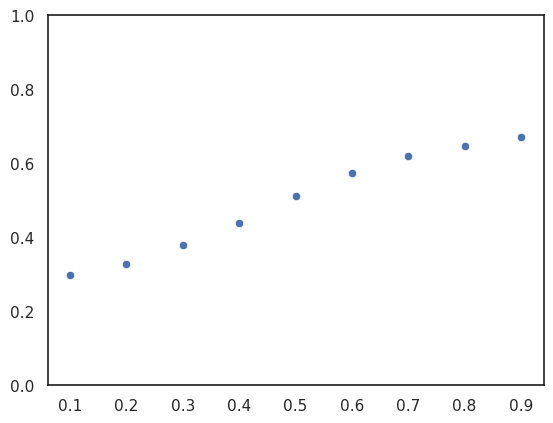

In [48]:
g = sns.scatterplot(x=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], y=x_div_q/aut_div_q)
g.set(ylim=(0, 1))

Autosomal runs of homozygosity.
Creating statistics based on single inds for this.

In [53]:
df_interval["sample_cohort"] = df_interval["samples"]
df_interval

<xarray.Dataset> Size: 6GB
Dimensions:               (windows: 267157, variants: 21463034, samples: 46,
                           ploidy: 2, contigs: 26, filters: 2,
                           region_index_values: 21487, region_index_fields: 6,
                           alleles: 2, intervals: 267165)
Coordinates:
  * samples               (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
Dimensions without coordinates: windows, variants, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles, intervals
Data variables: (12/23)
    window_contig         (windows) int64 2MB 0 0 0 0 0 0 ... 23 23 23 23 23 23
    window_start          (windows) int64 2MB 274 343 394 ... 21462731 21462756
    window_stop           (windows) int64 2MB 343 394 486 ... 21462756 21462791
    call_genotype         (variants, samples, ploidy) int8 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 2GB dask.array<chunksize=(1000, 46, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 987MB dask.array<chunksize=(1000, 46), meta=np.ndarray>
    ...                    ...
    variant_position      (variants) int32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 86MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 368B 0 1 2 3 4 5 ... 40 41 42 43 44 45
    interval_contig_name  (intervals) object 2MB 'NC_073230.2' ... 'NC_073247.2'
    interval_start        (intervals) int64 2MB 6435061 6589335 ... 167598696
    interval_stop         (intervals) int64 2MB 6445920 6599596 ... 167608697
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [103]:
# Setting missing values as 0/0 to allow for the windowing operation to work.
# As I'm just doing this as a windowed heterozygosity count, it doesn't change the results.
het_stats = df_interval
het_stats["call_genotype"] = het_stats["call_genotype"].clip(0)
het_stats = sg.diversity(het_stats)

<Axes: ylabel='Count'>

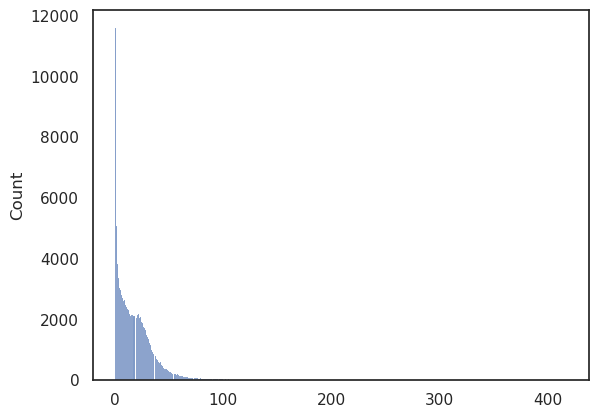

In [112]:
sns.histplot(het_stats.stat_diversity[:100000,0].values)